In [1]:
from torchvision import models, transforms
import torch
import os
from PIL import Image
import shutil
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tempfile

In [2]:
path = r'' + input('Enter a full path of your PC: ')
extensions = ['.png', '.jpeg', '.jpg']
temp_repo = tempfile.mkdtemp()

Enter a full path of your PC: C:\Users\danie\Desktop\Datascience


In [3]:
for root, dirs, files in os.walk(path):
    for i in files:
        name, ext = os.path.splitext(i)
        if ext in extensions:
            shutil.copy(os.path.join(root, i), temp_repo)

In [4]:
model = models.resnet18(pretrained=True)
feature_layer = model._modules.get('avgpool')
model.eval()
torch.device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(torch.device)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def get_feature_vector(img):
    transformed_img = transform(img).unsqueeze(0)
    result_vector = torch.zeros(1, 512, 1, 1)

  
    def copy_output(module, input, output):
        result_vector.copy_(output.data)

    hook = feature_layer.register_forward_hook(copy_output)
    model(transformed_img)    
    hook.remove()

    return result_vector.numpy()[0, :, 0, 0]

allVectors = {}
for image in tqdm(os.listdir(temp_repo)):
    I = Image.open(os.path.join(temp_repo, image)).convert('RGB')
    vector = get_feature_vector(I)
    allVectors[image] = vector
    I.close()       

100%|██████████| 1932/1932 [06:47<00:00,  4.74it/s]


In [5]:
def CosineSimilarity(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarity_matrix = CosineSimilarity(allVectors)

In [6]:
def require_similar_images():
    required_img = input('Choose the input image: ')
    df = similarity_matrix[required_img].sort_values(ascending=False).iloc[:][1:6]
    filenames = df.index
    values = df.values

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30,10))
    query = Image.open(os.path.join(temp_repo, required_img))
    ax1.imshow(query, aspect='auto')
    ax1.set_xlabel('Initial image', fontsize = 20)
    ax1.set_yticks([])
    ax1.set_xticks([])


    for name, value, ax in zip(filenames, values, [ax2, ax3, ax4, ax5]):
        img = Image.open(os.path.join(temp_repo, name))
        ax.imshow(img, aspect='auto')
        ax.set_ylabel('Similar image:{}'.format(name), fontsize=12)
        ax.set_xlabel('Similarity: {:.2%}'.format(value), fontsize=20)
        ax.set_yticks([])
        ax.set_xticks([])

    plt.show()

Choose the input image: 00000048_(6).jpg


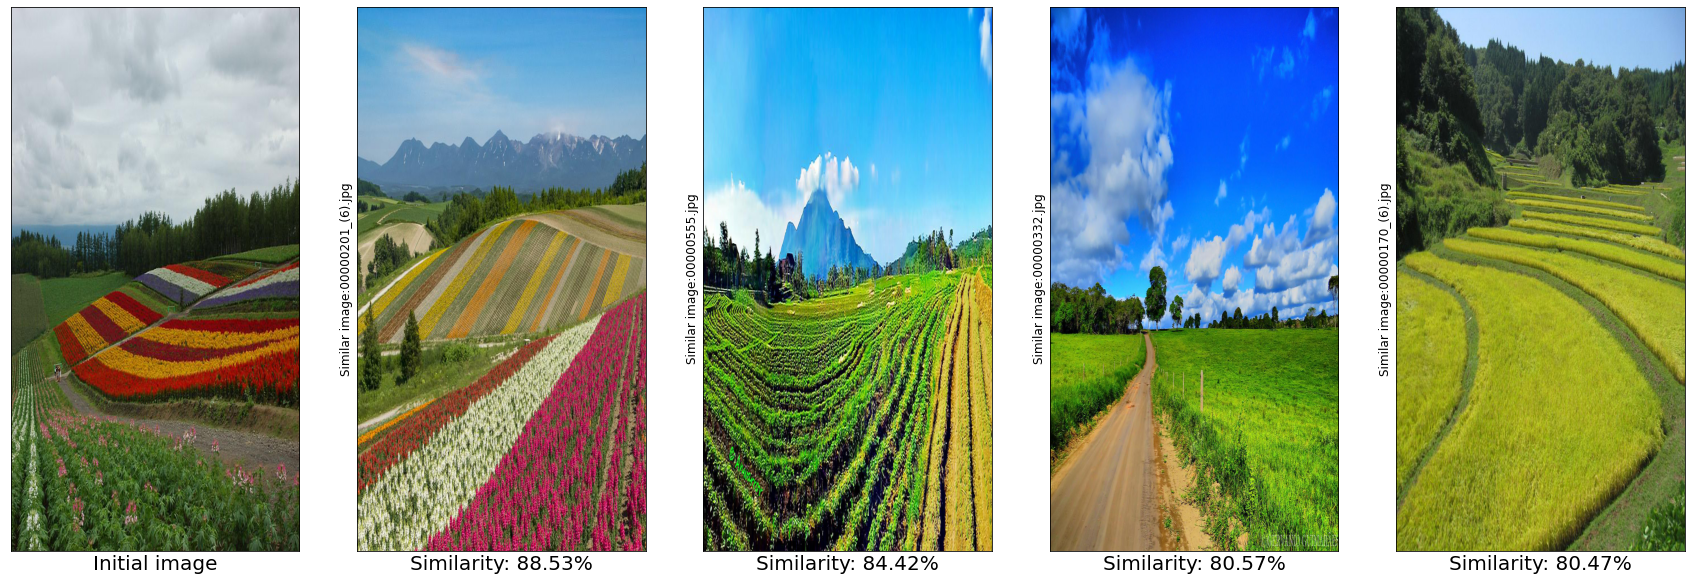

In [7]:
require_similar_images()

In [8]:
shutil.rmtree(temp_repo) 